# Extracting Car Radio Photos from my Photos Library

Often when I'm driving, I'll hear a song on the radio that I like. I've gotten in this bad habit
of using my phone while driving to take a quick picture of the radio (I only take photos when I'm stopped). The thought is that one day I'll go back through my photos, find the images of the car radio, then make a Spotify playlist. 

The first step is to build a DL model that can find all (or a reasonably good number of) the car radio photos. 

To accomplish this I have used PyTorch and osxphotos. The plan was to use transfer-learning from a previously built CNN on the fewest number of samples I could provide. 

## Training Data
First, I created a new album in my Photos library called "car radio". I hand-selected ~30 photos of the car radio that I was able to quickly find. These photos look like

<img src="IMG_3534.jpeg"  width="300">


## Photo Extraction & PyTorch Dataset
The `osxphotos` Python package reads the Photos.app SQLITE table and extracts a sufficient amount of information that I need. 

I define a custom Dataset class and a few helper functions

In [1]:
import time
import copy

import more_itertools
import osxphotos
import torchvision.transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.utils.data
from typing import List
import numpy as np
import torch 
import torchvision.models

from PIL import Image
from pillow_heif import register_heif_opener
register_heif_opener()
import matplotlib.pyplot as plt

class PhotosInfoDataset(Dataset):
    def __init__(self, 
                    photos_info: List[osxphotos.PhotoInfo], 
                    labels: List[int] | int, 
                    transform=torchvision.transforms.Compose([torchvision.transforms.PILToTensor()]), 
                    target_transform = None,
                 ):
        self.photos_info = photos_info
        if isinstance(labels, int):
            self.labels = [labels]*len(photos_info)
        else:
            self.labels = labels
        self.labels = np.array(self.labels)
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.photos_info)

    def __getitem__(self, idx):
        a_photo_info = self.photos_info[idx]
        image = Image.open(a_photo_info.path)

        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

def my_photos_dataset(transform=torchvision.transforms.Compose([torchvision.transforms.PILToTensor()]), 
                      album_name: str = None,
                      label: int = 0,
                      filter_funcs = [],
                      target_transform = None
                      ):
    photosdb = osxphotos.PhotosDB()
    photo_uuids = None

    photo_infos = photosdb.photos(uuid=photo_uuids, movies=False)
    photo_infos = list(filter(lambda x: x.path is not None, photo_infos))
    for f in filter_funcs:
        photo_infos = list(filter(f, photo_infos))

    return PhotosInfoDataset(photo_infos, label, transform=transform, target_transform=target_transform)


def composite_photos_dataset(db_datasets: List[PhotosInfoDataset],
                             transform=torchvision.transforms.Compose([torchvision.transforms.PILToTensor()]),
                             target_transform=None,
                             ):
        
    photo_infos = list(more_itertools.flatten([db.photos_info for db in db_datasets]))
    labels = np.concatenate([db.labels for db in db_datasets])
    return PhotosInfoDataset(photo_infos, labels, transform=transform, target_transform=target_transform)


To improve my chances of success, I noticed that all of my photos of the car radio were taken either with my iPhone 7 or SE -- the phones that I've had since I bought my Outback. These photos always had a fixed size, so I wrote a small filter function to select only photos of that size.

In [2]:
def fixed_shape(photo_info):
    vertical = (photo_info.width == 3024) and (photo_info.height == 4032)
    horizontal = (photo_info.height == 3024) and (photo_info.width == 4032)
    return vertical or horizontal 

In [3]:
def in_car_radio(photo_info):
    return 'car radio' in photo_info.albums

I also need some transformation functions to apply to the images.

For the training data I will use, I've added a random perspective operation in order to 
augment my training data set since 30 images of the positive class is quite small. 

In [42]:
crop_resize_tensor = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(3024),
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
])

In [ ]:
all_photo_dataset = my_photos_dataset(transform = crop_resize_tensor, 
                                      filter_funcs=[fixed_shape]

In [42]:
train_img_transform = torchvision.transforms.Compose([
    crop_resize_tensor,
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    torchvision.transforms.RandomPerspective(distortion_scale=0.25, p=.5),
])

val_img_transform = torchvision.transforms.Compose([
    crop_resize_tensor,
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [43]:
car_radio_dataset = my_photos_dataset(label = 1, transform = crop_resize, 
                             filter_funcs=[fixed_shape, in_car_radio])

2023-05-25 10:34:29,620 - root - WARNING - photosdb.py - 123 - WARNING: This module has only been tested with macOS versions [10.12, 10.13, 10.14, 10.15, 10.16, 11.0, 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 12.0, 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 13.0, 13.1, 13.2]: you have Darwin, OS version: 13.3


In [44]:
idx = 0
# a_photo_info = car_radio_dataset.photos_info[idx]
# image = Image.open(a_photo_info.path)
# image[0]

image = car_radio_dataset[idx][0]
#np.mean(image, axis=0)

In [54]:
image[0].std()

tensor(0.1648)

In [58]:
# cribbed from pytorch
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

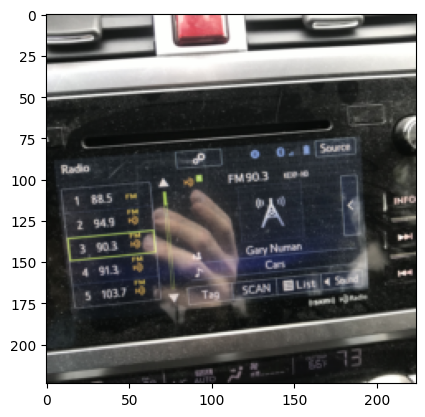

In [44]:
imshow(car_radio_dataset[0][0])

In [45]:
not_car_radio_dataset = my_photos_dataset(label = 1, transform = val_img_transform, 
                             filter_funcs=[fixed_shape, lambda x: ~in_car_radio(x)])

2023-05-09 15:22:50,360 - root - WARNING - photosdb.py - 123 - WARNING: This module has only been tested with macOS versions [10.12, 10.13, 10.14, 10.15, 10.16, 11.0, 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 12.0, 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 13.0, 13.1, 13.2]: you have Darwin, OS version: 13.3


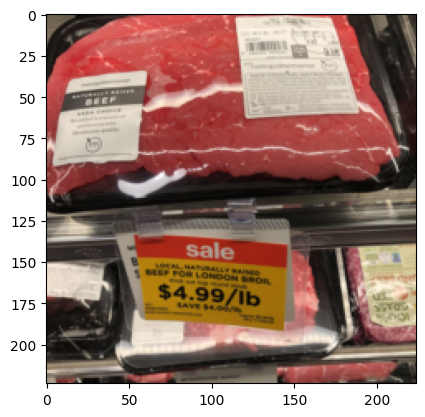

In [49]:
imshow(not_car_radio_dataset[int(np.random.random()*len(nocardb))][0])

### Generate Datasets

First, randomly pull from `nocardb` a small number of photos. To increase the number of photos for training, I'll double the number of images that are NOT of my car radio.
NB: there is no guarantee that I will not accidentally grab a picture that is of my car radio since not all of my actual car radio photos are in the 'car radio' album. But the odds are low. Even if a handful of photos are in my NO car radio dataset, it won't be the end of the world

In [50]:
zero_class_images = np.random.choice(not_car_radio_dataset.photos_info, 2*len(car_radio_dataset))
not_car_radio_subset = PhotosInfoDataset(zero_class_images, label = 0)

Note that the image transformation here in this dataset is 'train_img_transform' which includes randomized perspective changes for the purpose of augementation. 

In [51]:
train_val_dataset = composite_photos_dataset([not_car_radio_subset, car_radio_dataset],
                                   transform=train_img_transform,
                                   target_transform=None)

In [52]:
train_data, val_data = torch.utils.data.random_split(train_val_dataset, [.7, .3])

For validation data, however, we set the transform to not manipulate the perspective

In [54]:
val_data.dataset.transform = val_img_transform

In [55]:
train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=4, shuffle=True)

In [56]:
class_names = ['not radio', 'radio']
num_classes = 2

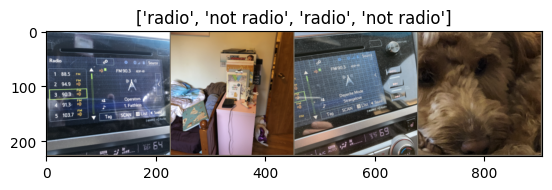

In [59]:
# Visualize a few samples
inputs, classes = next(iter(val_dataloader))
imshow(torchvision.utils.make_grid(inputs), title=[class_names[x] for x in classes])

## Train ResNet50 

Following the examples in the text, first define a function for training a new model

In [61]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

We will only train the final classifier layer rather than the full model.

In [69]:
device ='cpu'
model_conv = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

for param in model_conv.parameters():
    param.requires_grad = False
    
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = torch.nn.Linear(num_ftrs, num_classes)

model_conv = model_conv.to(device)

criterion = torch.nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized 
optimizer_conv = torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [70]:
dataloaders = {'train':train_dataloader, 'val': val_dataloader}
dataset_sizes = {'train':len(train_data), 'val': len(val_data)}

In [71]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=21)

Epoch 0/20
----------
train Loss: 0.6584 Acc: 0.5965
val Loss: 0.5234 Acc: 0.7500

Epoch 1/20
----------
train Loss: 0.5104 Acc: 0.8070
val Loss: 0.4356 Acc: 0.9167

Epoch 2/20
----------
train Loss: 0.5083 Acc: 0.7193
val Loss: 0.3881 Acc: 0.9583

Epoch 3/20
----------
train Loss: 0.4051 Acc: 0.8596
val Loss: 0.3270 Acc: 0.9583

Epoch 4/20
----------
train Loss: 0.3568 Acc: 0.8246
val Loss: 0.3132 Acc: 0.9583

Epoch 5/20
----------
train Loss: 0.3421 Acc: 0.8596
val Loss: 0.2884 Acc: 0.9583

Epoch 6/20
----------
train Loss: 0.3889 Acc: 0.8596
val Loss: 0.2789 Acc: 0.9583

Epoch 7/20
----------
train Loss: 0.3700 Acc: 0.8246
val Loss: 0.2959 Acc: 0.9583

Epoch 8/20
----------
train Loss: 0.3873 Acc: 0.8421
val Loss: 0.2969 Acc: 0.9583

Epoch 9/20
----------
train Loss: 0.4185 Acc: 0.8070
val Loss: 0.2931 Acc: 0.9583

Epoch 10/20
----------
train Loss: 0.2922 Acc: 0.9298
val Loss: 0.2925 Acc: 0.9583

Epoch 11/20
----------
train Loss: 0.2948 Acc: 0.9123
val Loss: 0.2957 Acc: 0.9583

Ep

## See how we did.

I'm not going to use the validation set above to visualize how well I performed, but rather will scroll through my photos by hand. 